# Mini-Bird Experiment
---

### Import and Functions

In [9]:
import sys
import os
import json
import argparse
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.interpolate import PchipInterpolator


load_dotenv()
sys.path.append(os.path.abspath("..")) 

from MM.model_selector import ModelSelector
from MM.agent.llm import LLMAgent


/home/yosef/miniconda3/envs/mm/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [10]:
def load_data(test_path):
    assert test_path.endswith(".jsonl"), f"Invalid test_path, must be a valid jsonl file: {test_path}"
    with open(test_path, "r") as f:
        task_configs = [json.loads(line) for line in f]
    
    return task_configs

In [11]:
def selector_config()->argparse.Namespace:
    parser = argparse.ArgumentParser(
        description=f"Initiate config for Model Selector"
    )

    #General
    parser.add_argument("--n_cluster", type=int, default=5)
    parser.add_argument("--sample_rate", type=float, default=0.06)

    #Thompson
    parser.add_argument("--prior_size", type=int, default=16)

    #Succesive Reject
    parser.add_argument("--eval_size", type=int, default=16)
    parser.add_argument("--strategy", default="vanilla", help="['vanilla', 'halving']")
    

    #UCB
    parser.add_argument("--eval_rate", type=float, default=0.1)
    parser.add_argument("--k_model", type=int, default=3)
    parser.add_argument("--coeff", type=float, default=0.5)
    parser.add_argument("--rounds", type=int, default=10)

    args = parser.parse_known_args()
    return args

In [12]:
def model_config(model:str, cost: float) -> argparse.Namespace:
    parser = argparse.ArgumentParser(
        description=f"Initiate config for {model}"
    )
    
    #Path settings
    parser.add_argument("--system_prompt_path", help="System prompt file path", default="/home/yosef/ace/mm/MM/agent/prompts/bird_prompt.txt")
    parser.add_argument("--databases_path", help="Databases directory path", default="/home/yosef/ace/mm/MM/dataset/minidev_0703/minidev/MINIDEV/dev_databases")
    parser.add_argument("--gold_path", help="Query evaluation path", default="/home/yosef/ace/mm/MM/dataset/minidev_0703/minidev/gold")
    parser.add_argument("--condition_path", help="Evaluation condition path", default="/home/yosef/ace/mm/MM/dataset/minidev_0703/minidev/minibird.jsonl")

    #LLM settings
    parser.add_argument("--model", type=str, default = model)
    parser.add_argument("--cost", type=float, default = cost)
    parser.add_argument("--temperature", type=float, default=0.0)
    parser.add_argument("--top_p", type=float, default=1.0)
    parser.add_argument("--max_new_tokens", type=int, default=4000)
    parser.add_argument("--stop_token", type=str, default=None)
    parser.add_argument("--prompt_strategy", default="bird-agent", 
                       choices=["bird-agent"],
                       help="Prompt building strategy")

    # Execution settings
    parser.add_argument("--api_host", default="localhost", help="API host")
    parser.add_argument("--api_port", default="5000", help="API port")
    parser.add_argument("--max_rounds", type=int, default=10, help="Max conversation rounds")
    parser.add_argument("--num_threads", type=int, default=4, help="Number of threads")
    parser.add_argument("--rollout_number", type=int, default=1, help="Number of rollouts per example")

    # Evaluation settings
    parser.add_argument("--max_query", type=int , default=50000, help="Number of max row")
    parser.add_argument("--env", default="postgre", help="Environment for SQL excution ")
    parser.add_argument("--db_name", help="DB name", default=os.environ["DB_NAME"])
    parser.add_argument("--username", help="SQL username", default=os.environ["DB_USER"])
    parser.add_argument("--password", help="SQL password", default=os.environ["DB_PASSWORD"])
    parser.add_argument("--host", help="DB host", default=os.environ["DB_HOST"])
    parser.add_argument("--port", help="DB port", default=os.environ["DB_PORT"])

    args = parser.parse_known_args()
    return args

In [20]:

def plot_pf_sorted(data, filename=None):
    df = pd.DataFrame(data)
    df_sorted = df.sort_values("Cost", ascending=True).reset_index(drop=True)

    frontier_idx = []
    max_score_so_far = -np.inf
    for idx, row in df_sorted.iterrows():
        if row["Score"] > max_score_so_far:
            frontier_idx.append(idx)
            max_score_so_far = row["Score"]
    pf = df_sorted.loc[frontier_idx]

    fig, ax = plt.subplots(figsize=(12, 7))
    sns.set(style="whitegrid", font_scale=1.2)

    if len(pf) >= 2:
        log_c = np.log(pf["Cost"].values)
        scores = pf["Score"].values
        spline = PchipInterpolator(log_c, scores)

        log_xs = np.linspace(log_c.min(), log_c.max(), 300)
        xs = np.exp(log_xs)
        ys = spline(log_xs)

        ax.plot(
            xs, ys,
            color="red", linewidth=1.5, zorder=1, alpha=0.6,
            label="_nolegend_"
        )
    elif len(pf) == 2:
        ax.plot(
            pf["Cost"], pf["Score"],
            color="red", linewidth=1.5, zorder=1, alpha=0.6,
            label="_nolegend_"
        )

    sns.scatterplot(
        x="Cost", y="Score",
        hue="Model",
        palette="tab20",
        data=df_sorted,
        s=120,
        edgecolor="white",
        linewidth=1.2,
        ax=ax,
        legend="full",
        zorder=2
    )

    ax.set_xscale("log")
    cost_ticks = df_sorted["Cost"].unique()
    ax.set_xticks(cost_ticks)
    ax.set_xticklabels([f"{c:g}" for c in cost_ticks])

    ax.set_xlim(0.1, 50)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Cost Input and Output ($/1 M Tokens)", fontsize=13)
    ax.set_ylabel("Arena Score", fontsize=13)

    ax.legend(
        title="Model",
        loc="best",
        frameon=True,
        framealpha=0.8
    )

    ax.grid(True, which="both", linestyle="--", linewidth=0.3, alpha=0.25)
    plt.tight_layout()

    if filename:
        fig.savefig(filename, bbox_inches="tight", dpi=300)

    plt.show()
    return fig, ax


### Main

In [ ]:
import subprocess

subprocess.Popen(
    ["bash", "/home/yosef/ace/mm/experiments/run_server.sh"],
    stdout=None,
    stderr=subprocess.STDOUT
)


In [15]:
plafortm_conf = selector_config()
configs = [model_config("google/gemini-2.0-flash-001",0.225), model_config("google/gemini-2.5-flash",0.45), model_config("google/gemini-2.5-pro",2.5)]

dataset = load_data(os.path.join(os.path.abspath(".."),"MM/dataset/minidev_0703/minidev/minibird.jsonl"))
models = list()
for conf in configs:
    models.append(LLMAgent(conf[0]))

selector = ModelSelector( models=models, args=plafortm_conf[0])


/home/yosef/miniconda3/envs/mm/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Cluster sampling

In [13]:
cs_res = selector.cluster_sampling(dataset)
print(cs_res)

[16:44:47] Start Sampling
[16:44:47] Start Evaluating LLMAgent(name=google/gemini-2.0-flash-001)
[16:45:01] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 1482 | Scored :False
[16:45:07] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 1378 | Scored :False
[16:45:12] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 1394 | Scored :False
[16:45:19] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 1422 | Scored :False
[16:46:07] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 1162 | Scored :False
[16:46:51] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 1251 | Scored :False
[16:47:07] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 1036 | Scored :False
[16:47:26] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 1144 | Scored :False
[16:48:00] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 1145 | Scored :True
[16:48:09] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 884 | Scored :False
[16:48:15] LLMAgent(name=google/gem

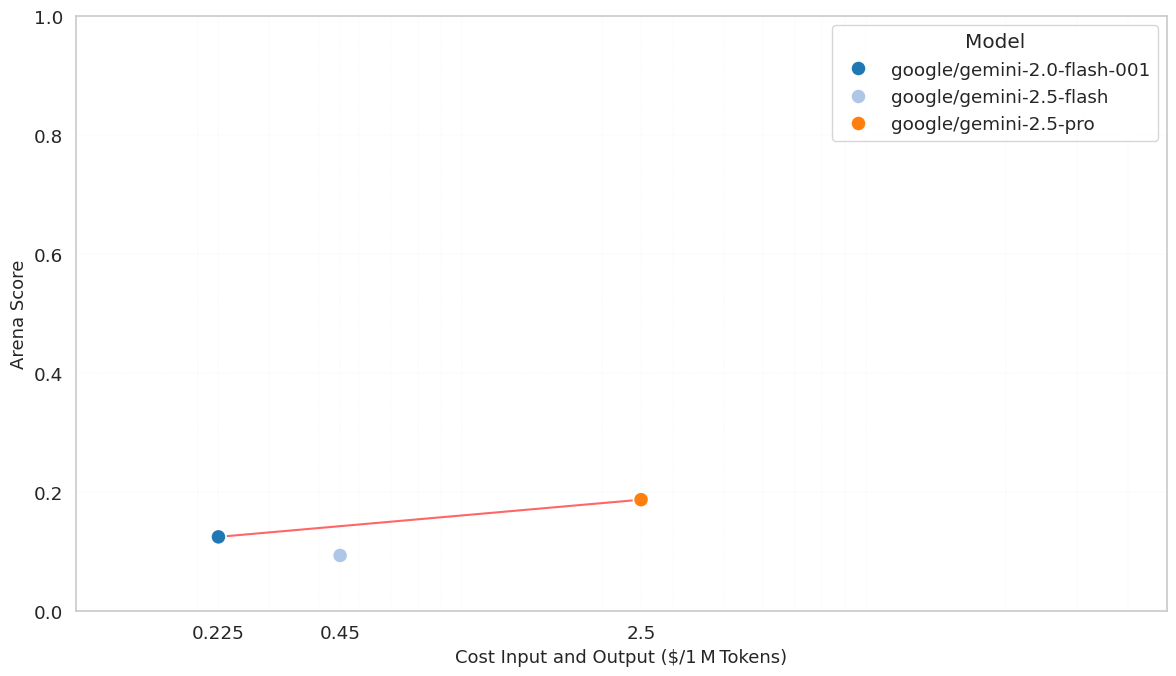

(<Figure size 1200x700 with 1 Axes>,
 <Axes: xlabel='Cost Input and Output ($/1\u202fM\u202fTokens)', ylabel='Arena Score'>)

In [ ]:
cs_shw = []
for idx,conf in enumerate(configs):
    cs_shw.append({
        "Model":conf[0].model,
        "Cost": conf[0].cost,
        "Score":cs_res[idx]
    })

plot_pf_sorted(cs_shw,"cs_bird.png")

### Cluster sampling + Thompson sampling 

In [8]:
csts_res = selector.cluster_sampling_thompson(dataset)
print(csts_res)

[03:41:02] Start Sampling
[03:41:04] Start Computing prior LLMAgent(name=google/gemini-2.0-flash-001)
[03:41:17] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 347 | Not Terminated!
[03:41:39] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 897 | Scored :True
[03:42:16] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 1068 | Scored :False
[03:42:22] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 989 | Scored :True
[03:42:27] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 282 | Scored :False
[03:43:27] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 120 | Scored :False
[03:44:11] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 682 | Not Terminated!
[03:44:15] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 136 | Scored :False
[03:44:28] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 1155 | Scored :False
[03:45:11] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 194 | Scored :False
[03:45:19] LLMAgent(name=google/ge

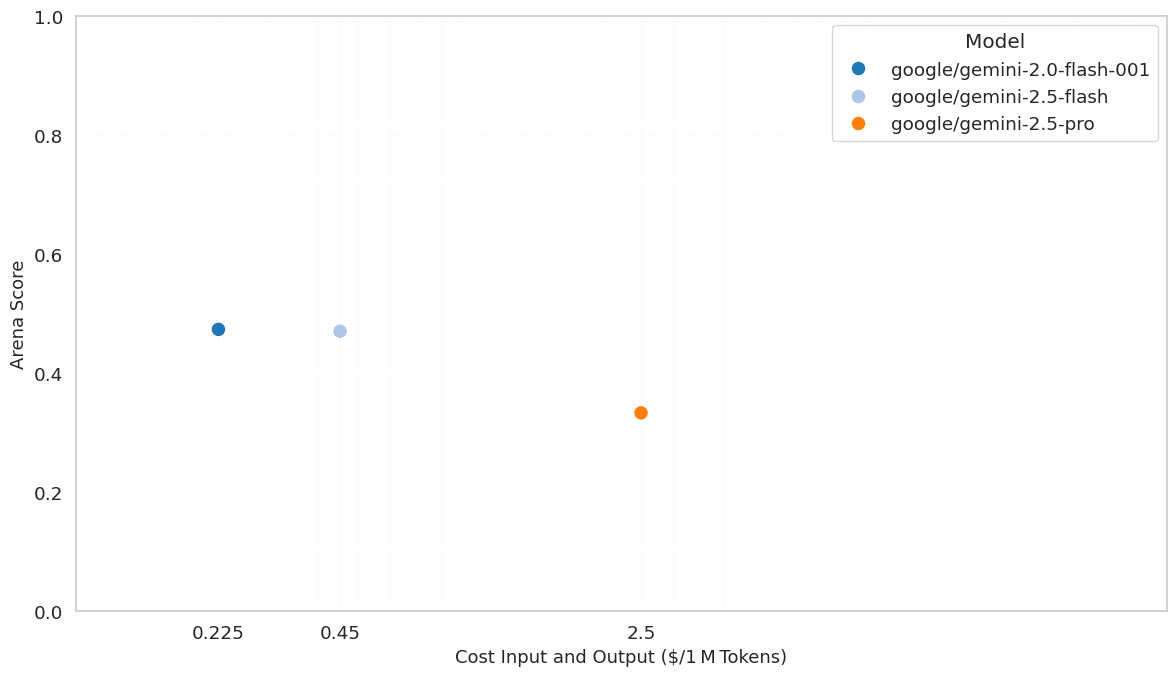

(<Figure size 1200x700 with 1 Axes>,
 <Axes: xlabel='Cost Input and Output ($/1\u202fM\u202fTokens)', ylabel='Arena Score'>)

In [24]:
csts_shw = []
for idx,conf in enumerate(configs):
    csts_shw.append({
        "Model":conf[0].model,
        "Cost": conf[0].cost,
        "Score":csts_res[idx]
    })

plot_pf_sorted(csts_shw,"csts_bird.png")


### Succesive Reject

In [8]:
sr_res = selector.succesive_reject(dataset)
print(sr_res)

[14:11:56] Start Sampling
[14:12:09] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 1484 | Scored :True
[14:12:33] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 1339 | Scored :True
[14:13:19] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 1405 | Scored :True
[14:13:25] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 1155 | Scored :False
[14:14:13] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 1238 | Scored :True
[14:14:29] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 1247 | Scored :False
[14:15:19] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 1057 | Scored :False
[14:15:28] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 1068 | Scored :False
[14:16:17] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 1115 | Scored :False
[14:16:38] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 896 | Scored :False
[14:17:24] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 897 | Scored :True
[14:17:29] LLMAgent(name

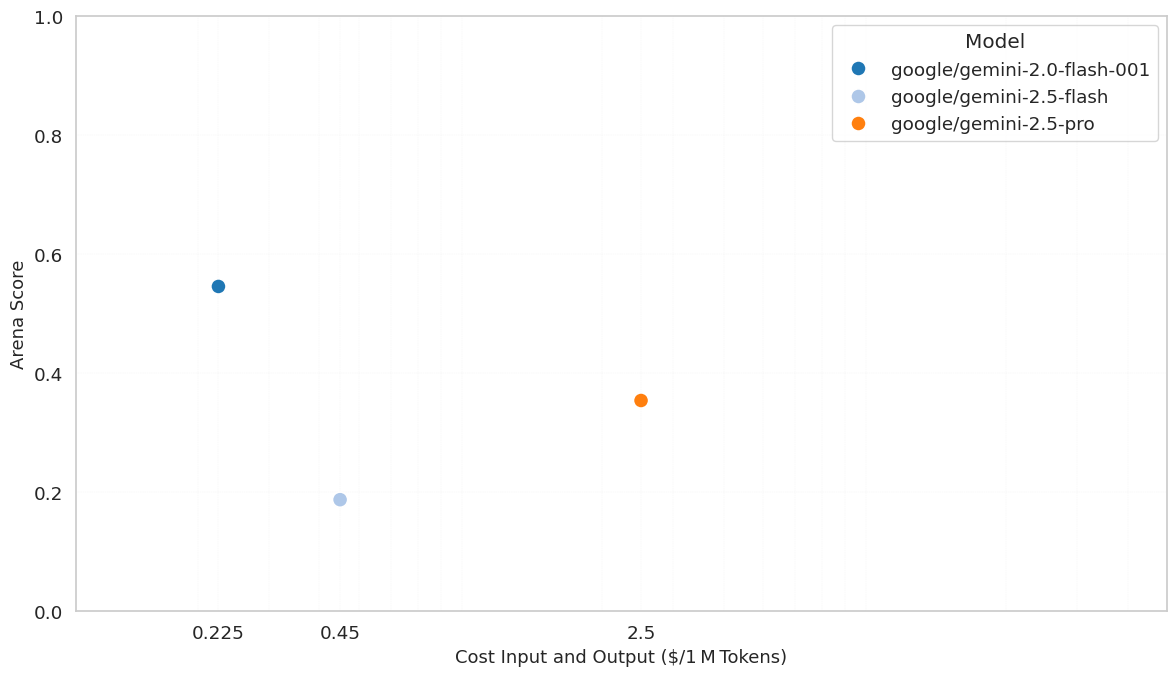

(<Figure size 1200x700 with 1 Axes>,
 <Axes: xlabel='Cost Input and Output ($/1\u202fM\u202fTokens)', ylabel='Arena Score'>)

In [ ]:
df = pd.DataFrame(sr_res)
df_filled = df.fillna(0)
col_avg = df_filled.mean().tolist()

sr_shw = []
for idx,conf in enumerate(configs):
    sr_shw.append({
        "Model":conf[0].model,
        "Cost": conf[0].cost,
        "Score":col_avg[idx]
    })
plot_pf_sorted(sr_shw,"sr_bird.png")


### UCB

In [8]:
ucb_res = selector.ucb(dataset)
print(ucb_res)

[18:58:06] Start Sampling
[18:58:26] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 347 | Not Terminated!
[18:58:43] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 897 | Scored :True
[18:58:58] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 1068 | Scored :False
[18:59:05] LLMAgent(name=google/gemini-2.5-flash) | Instance: 230 | Scored :False
[18:59:16] LLMAgent(name=google/gemini-2.5-flash) | Instance: 1484 | Scored :True
[19:00:24] LLMAgent(name=google/gemini-2.5-flash) | Instance: 32 | Not Terminated!
[19:01:31] LLMAgent(name=google/gemini-2.5-pro) | Instance: 1339 | Scored :True
[19:01:49] LLMAgent(name=google/gemini-2.5-pro) | Instance: 1238 | Scored :False
[19:03:00] LLMAgent(name=google/gemini-2.5-pro) | Instance: 1247 | Scored :False
[19:03:15] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 796 | Scored :True
[19:03:33] LLMAgent(name=google/gemini-2.0-flash-001) | Instance: 1155 | Not Terminated!
[19:03:54] LLMAgent(name=google/gemini-2.0-flash-00

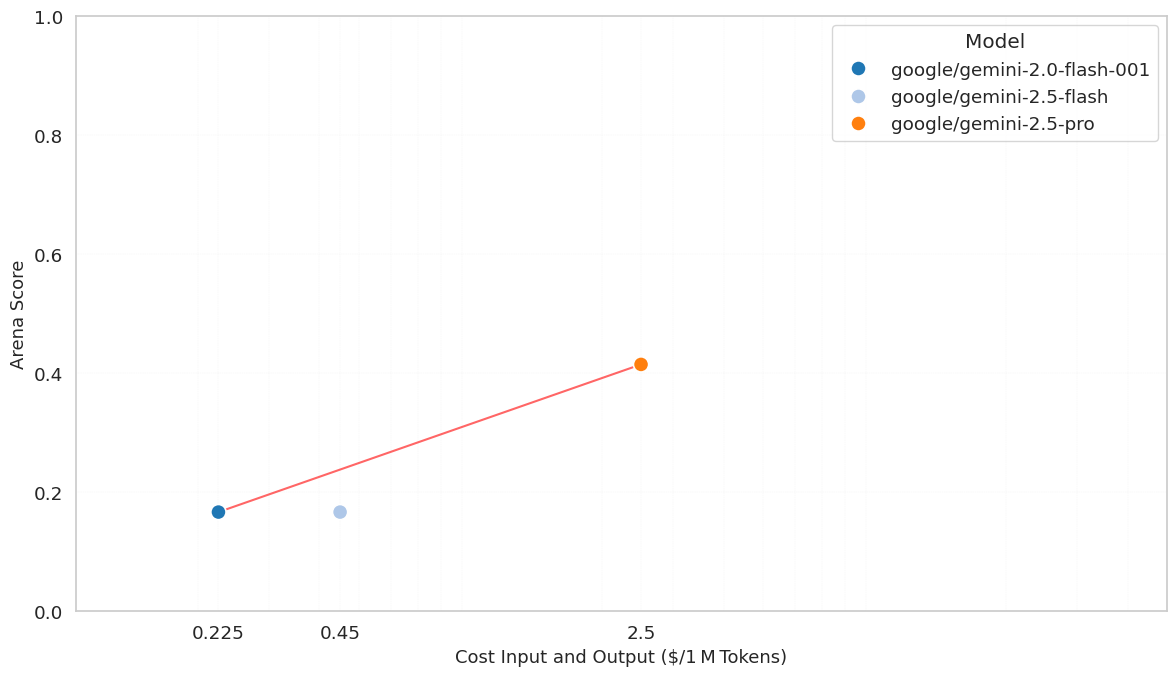

(<Figure size 1200x700 with 1 Axes>,
 <Axes: xlabel='Cost Input and Output ($/1\u202fM\u202fTokens)', ylabel='Arena Score'>)

In [23]:
ucb_shw = []
for res in ucb_res:
    ucb_shw.append({
        "Model":configs[res[0]][0].model,
        "Cost": configs[res[0]][0].cost,
        "Score":res[2]
    })
plot_pf_sorted(ucb_shw,"ucb_bird.png")
